In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import ceil
from scipy.stats import pearsonr

/var/folders/pv/4pndnly93037qw_7vqb_7m3c0000gp/T/ipykernel_1770/3899131392.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


This notebooks creates the visualisations of a part of the time series of CPU usage (y-axis) across time (x-axis) for job 113, as shown in the Figure 2 of the paper, that allows to better understand the ML-based predictions.The first figure compares the predicted time series to the ground truth. Each box depicts different parts of the time series, where the predicted one is derived following the three different experiments described in the section 2.1 of the paper, using the trained model of job 113 for experiments A, B and job 917 for experiment C. The number on the upper right of each box shows the Pearson correlation coefficient value between the two depicted time series.

In [4]:
job_labels = ['113', '917']
job_ids = ['113812204462', '91724979887']

In [5]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [6]:
left = [] # 113 0
center = [] # 113 3
right = [] # 917 0

In [7]:
for ind, job_id in enumerate(job_ids):
    job_label = job_labels[ind]
    columns_to_use = ['avg_cpu_usage', 'time']
    time_col = 'time'
    col = 'avg_cpu_usage'
    time_unit = 'us'
    freq = '5min'

    # folder path
    dir_path = r'input-large/' + job_id + '/'

    # list to store files
    list_of_files = []

    # Iterate directory
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            list_of_files.append(path)
              
    csv_data_list = []
    for i in list_of_files:
        type(i)
        dir = 'input-large/' +job_id + '/' + i 
        csv_data_list.append(pd.read_csv(filepath_or_buffer=dir, usecols=columns_to_use))

    data = []
    for df in csv_data_list:
        df[time_col] = pd.to_datetime(
        df[time_col], unit=time_unit)
        df.set_index(time_col, inplace=True)
        df = df[~df.index.duplicated(keep="first")]
        df = df.resample(freq).mean()
        df = df.asfreq(freq=freq, method="ffill")
        df = df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
        data.append(df)
    
    for mod_index, model_id in enumerate(job_ids):
        model_label = job_labels[mod_index]
        number_of_tasks = len(list_of_files)
        for i in range (0, number_of_tasks):
            x_test = data[i][:800]['avg_cpu_usage']
            n_features = 1
            n_steps = 30

            a = min(x_test)
            b = max(x_test)
            x_test_normalised = []
            for x in x_test:
                x_test_normalised.append(((x-a)/(b-a)))

            # split into samples
            X_test, y_test = split_sequence(x_test_normalised, n_steps)
            X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
                            
            model = keras.models.load_model('job' + model_id + '/newbaseline_model/model') #LSTM model directory
            m = model
            yh = m.predict(X_test, verbose=0)

            y_denorm = []
            for y in yh:
                y_denorm.append(y*((b)-(a)) + (a))

            if i == 0 and model_id == '113812204462' and job_id == '113812204462':
                print("LSTM & Non-ML correlation")
                job5 = np.concatenate(y_denorm[0:100], axis=0)
                cor1prev = pearsonr(job5,x_test[29:129])[0]
                print(pearsonr(job5,x_test[29:129])[0])
                print("LSTM & ground truth correlation")
                cor1gt = pearsonr(job5,x_test[30:130])[0]
                print(pearsonr(job5,x_test[30:130])[0])
                left.append(y_denorm[0:100])
                left.append(x_test[29:129])
                left.append(x_test[30:130])
            if i == 3 and model_id == '113812204462' and job_id == '113812204462':
                print("LSTM & Non-ML correlation")
                job5 = np.concatenate(y_denorm[0:100], axis=0)
                cor2prev = pearsonr(job5,x_test[29:129])[0]
                print(pearsonr(job5,x_test[29:129])[0])
                print("LSTM & ground truth correlation")
                corr2gt = pearsonr(job5,x_test[30:130])[0]
                print(pearsonr(job5,x_test[30:130])[0])
                center.append(y_denorm[0:100])
                center.append(x_test[29:129])
                center.append(x_test[30:130])
            if i == 0 and model_id == '91724979887' and job_id == '113812204462':
                print("LSTM & Non-ML correlation")
                job5 = np.concatenate(y_denorm[0:100], axis=0)
                corr3prev = pearsonr(job5,x_test[29:129])[0]
                print(pearsonr(job5,x_test[29:129])[0])
                print("LSTM & ground truth correlation")
                corr3gt = pearsonr(job5,x_test[30:130])[0]
                print(pearsonr(job5,x_test[30:130])[0])
                right.append(y_denorm[0:100])
                right.append(x_test[29:129])
                right.append(x_test[30:130])

2023-09-18 15:22:03.372683: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


LSTM & Non-ML correlation
0.992242326151896
LSTM & ground truth correlation
0.9239626816654886
LSTM & Non-ML correlation
0.9870979958036656
LSTM & ground truth correlation
0.8953851141063045
LSTM & Non-ML correlation
0.9854987419377778
LSTM & ground truth correlation
0.9206823387994536


Figure 2a.

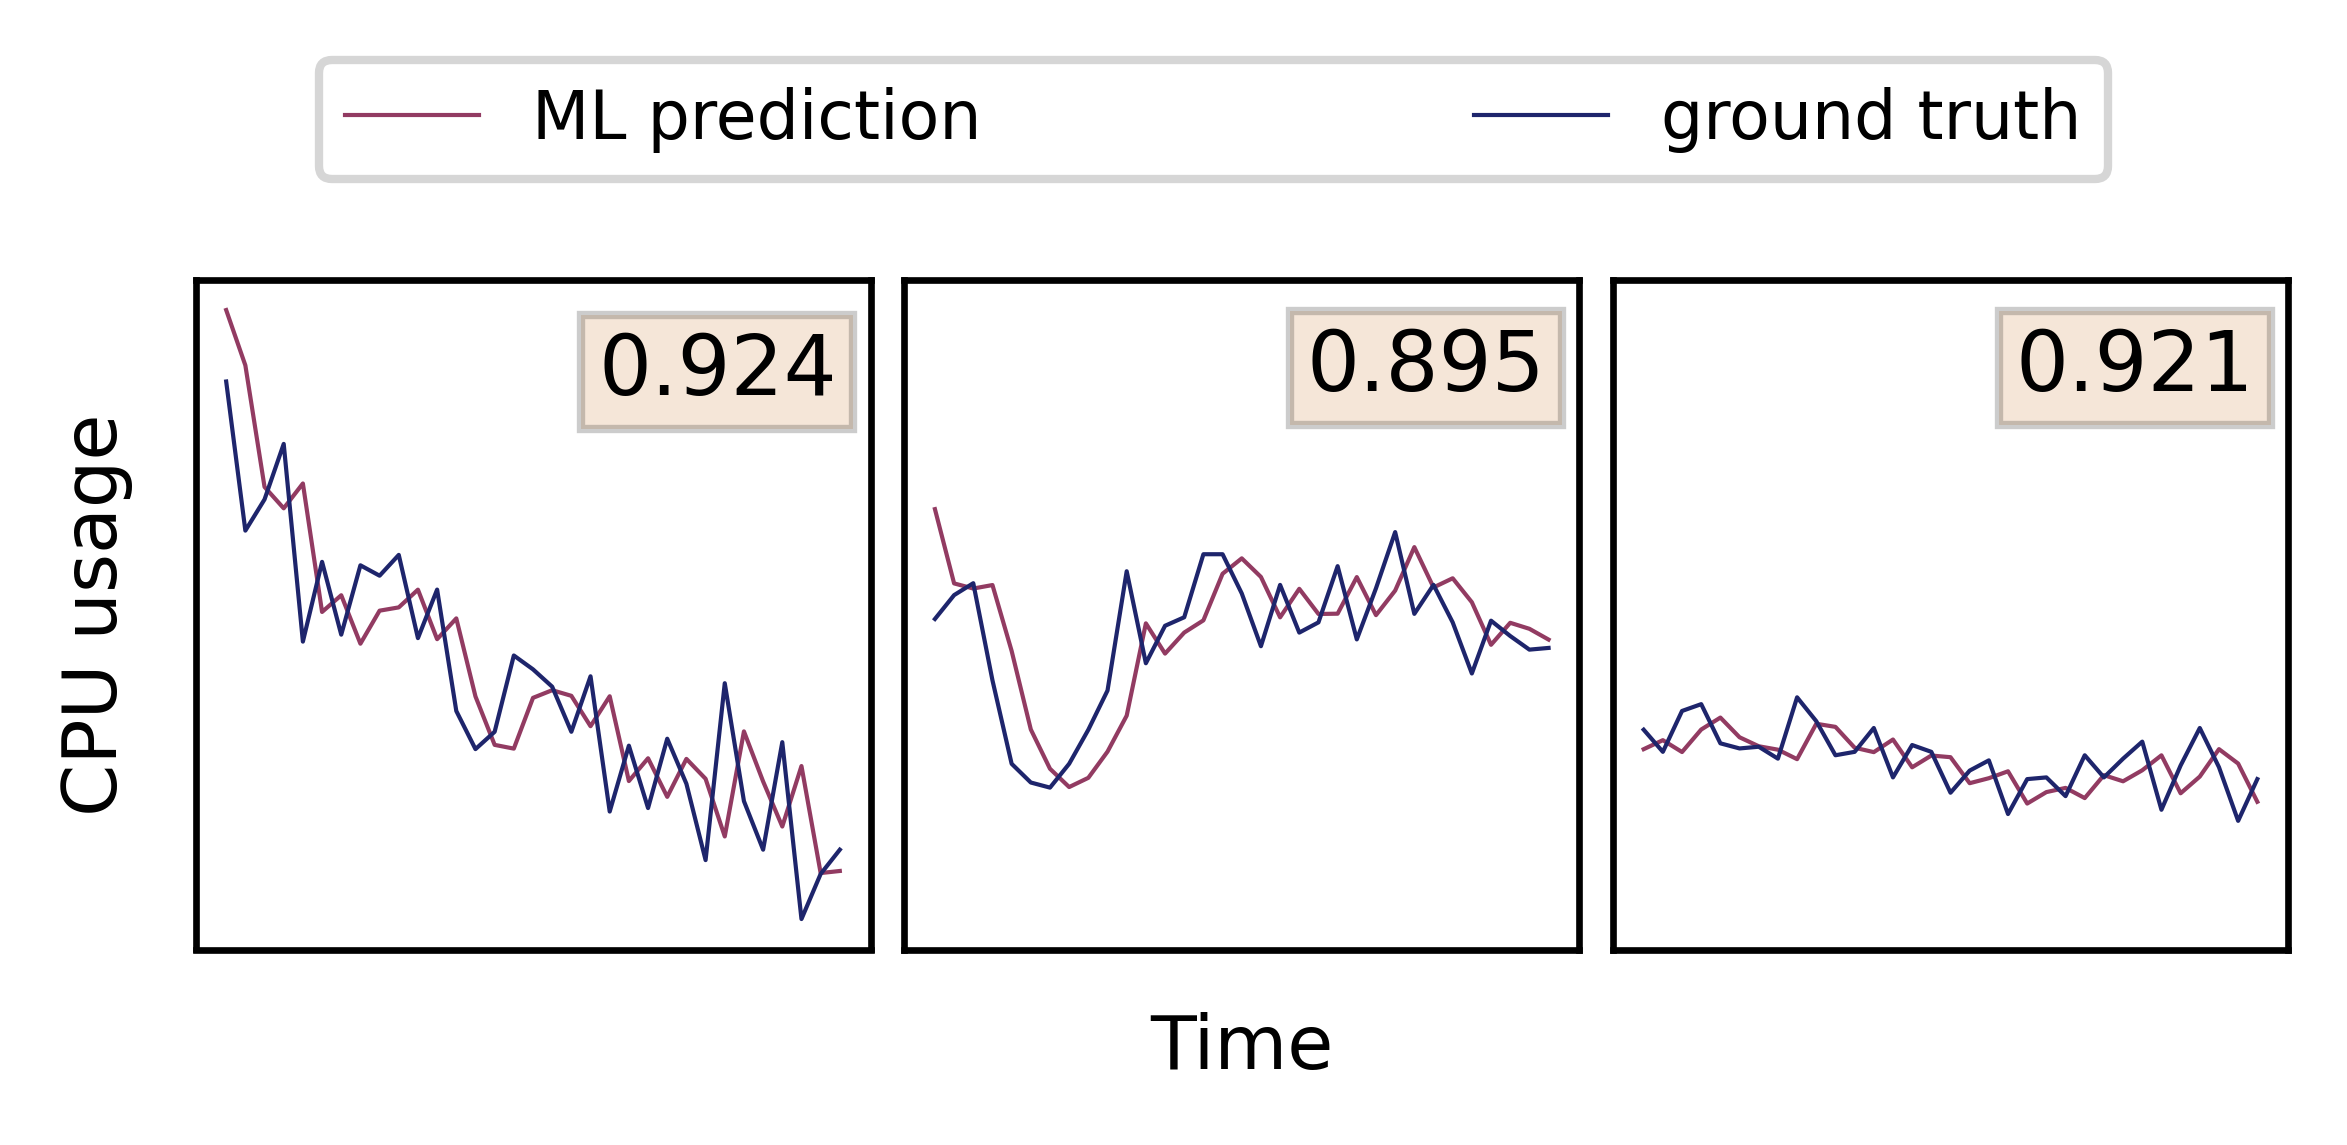

In [10]:
lw = 0.5
fig, axs = plt.subplots(1, 3, figsize=(4.5,1.45), dpi=600)
fig.subplots_adjust(wspace=0.05)
bins = np.linspace(0, 33, 33)

y_ticks = [0.013, 0.016, 0.019, 0.022, 0.025]
y_tick_labels = ['1.3', '1.6', '1.9', '2.2', '2.5']

# 1st square
axs[0].plot(bins, left[0][:33], alpha=1, color="#923b62", label='ML prediction', linewidth=lw)
axs[0].plot(bins, left[2].iloc[:33], alpha=1, color="#1e256c", label='ground truth', linewidth=lw)
axs[0].set_ylabel("CPU usage", size = 9)

axs[0].yaxis.set_ticks([])
axs[0].yaxis.set_ticklabels([])
axs[0].tick_params(axis='y', labelsize=8)

axs[0].xaxis.set_ticks([])
axs[0].xaxis.set_ticklabels([])
axs[0].tick_params(axis='x', labelsize=8)

axs[0].margins(0.05, 0.05)

# 2nd square
axs[1].plot(bins, center[0][33:66], alpha=1, color="#923b62",label='ML prediction', linewidth=lw)
axs[1].plot(bins, center[2].iloc[33:66], alpha=1, color="#1e256c",label='ground truth', linewidth=lw)
axs[1].set_xlabel('Time', size = 9)

axs[1].yaxis.set_ticks([])
axs[1].yaxis.set_ticklabels([])
axs[1].tick_params(axis='y', labelsize=8)
axs[1].set_ylim(y_ticks[0], y_ticks[-1])

axs[1].xaxis.set_ticks([])
axs[1].xaxis.set_ticklabels([])
axs[1].tick_params(axis='x', labelsize=8)

axs[1].margins(0.05, 0.05)
axs[1].legend().set_visible(False)

# 3rd square
axs[2].plot(bins, right[0][66:99], alpha=1, color="#923b62",label='ML prediction', linewidth=lw)
axs[2].plot(bins, right[2].iloc[66:99], alpha=1, color="#1e256c",label='ground truth', linewidth=lw)

axs[2].yaxis.set_ticks([])
axs[2].yaxis.set_ticklabels([])
axs[2].tick_params(axis='y', labelsize=8)
axs[2].set_ylim(y_ticks[0], y_ticks[-1])

axs[2].xaxis.set_ticks([])
axs[2].xaxis.set_ticklabels([])
axs[2].tick_params(axis='x', labelsize=8)

axs[2].margins(0.05, 0.05)
axs[2].legend().set_visible(False)

axs[0].text(20, 0.02234, str(round(cor1gt, 3)),
        bbox={'facecolor': 'peru', 'alpha': 0.2, 'pad': 2})

axs[1].text(20, 0.023, str(round(corr2gt, 3)),
        bbox={'facecolor': 'peru', 'alpha': 0.2, 'pad': 2})

axs[2].text(20, 0.023, str(round(corr3gt, 3)),
        bbox={'facecolor': 'peru', 'alpha': 0.2, 'pad': 2})

axs[0].legend(loc='lower center', bbox_to_anchor=(0.133, 1.1, 2.75, .1), fontsize=8, ncols=2, handlelength=2, mode='expand')

plt.show()

Figure 2b.

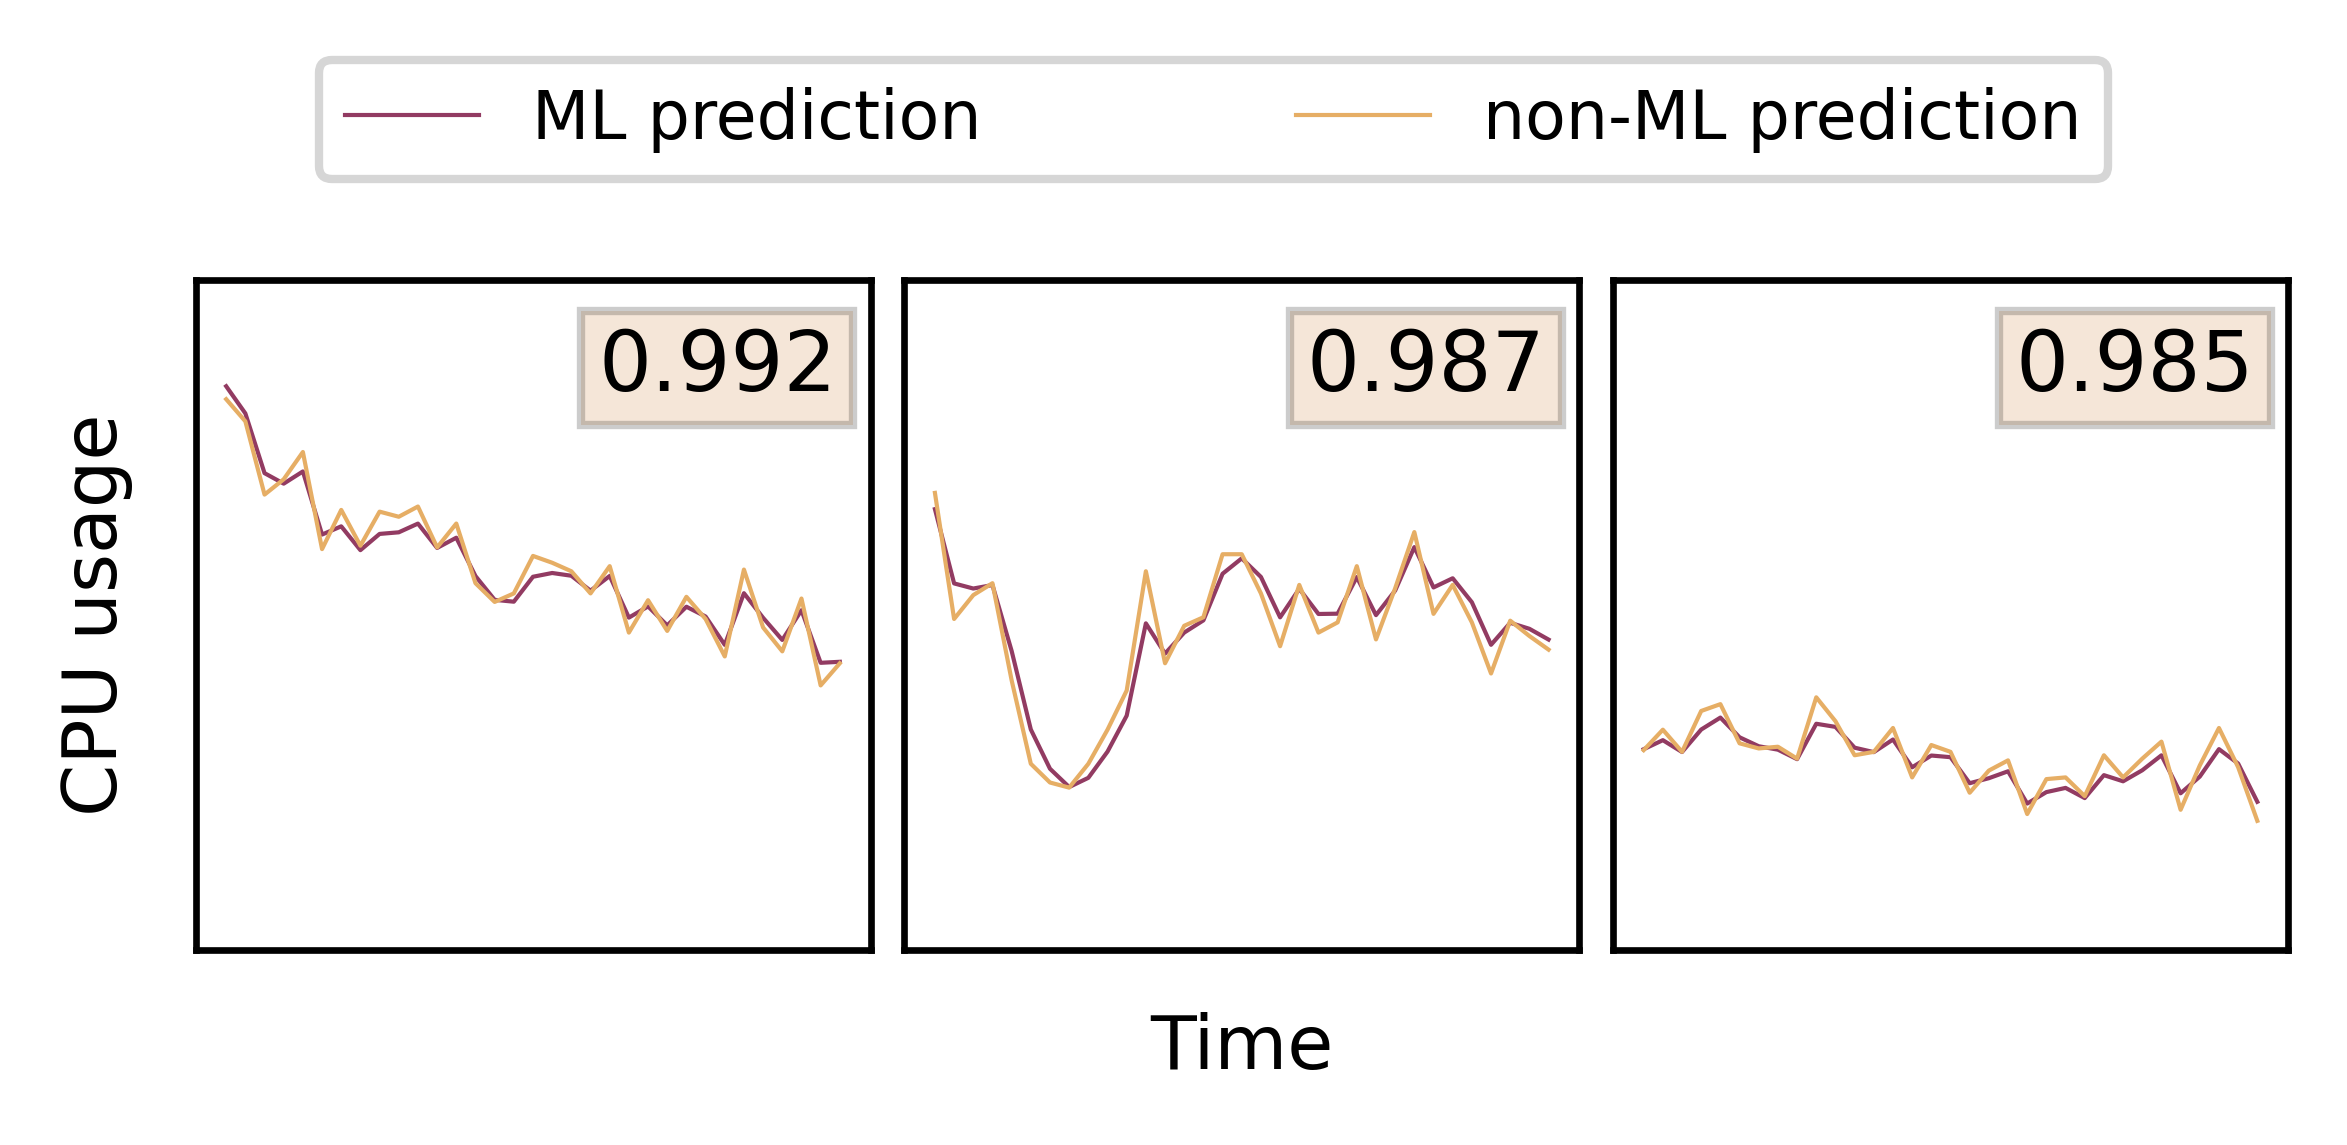

In [9]:
lw = 0.5
fig, axs = plt.subplots(1, 3, figsize=(4.5,1.45), dpi=600)
fig.subplots_adjust(wspace=0.05)
bins = np.linspace(0, 33, 33)

# 1st square
axs[0].plot(bins, left[0][:33], alpha=1, color="#923b62", label='ML prediction', linewidth=lw)
axs[0].plot(bins, left[1].iloc[:33], alpha=1, color="#e6ae65", label='non-ML prediction', linewidth=lw)
axs[0].set_ylabel("CPU usage", size = 9)

y_ticks = [0.013, 0.016, 0.019, 0.022, 0.025]
y_tick_labels = ['1.3', '1.6', '1.9', '2.2', '2.5']
axs[0].yaxis.set_ticks([])
axs[0].yaxis.set_ticklabels([])
axs[0].tick_params(axis='y', labelsize=8)
axs[0].set_ylim(y_ticks[0], y_ticks[-1])

axs[0].xaxis.set_ticks([])
axs[0].xaxis.set_ticklabels([])
axs[0].tick_params(axis='x', labelsize=8)

axs[0].margins(0.05, 0.05)

# 2nd square
axs[1].plot(bins, center[0][33:66], alpha=1, color="#923b62",label='ML prediction', linewidth=lw)
axs[1].plot(bins, center[1].iloc[33:66], alpha=1, color="#e6ae65",label='non-ML prediction', linewidth=lw)
axs[1].set_xlabel('Time', size = 9)

axs[1].yaxis.set_ticks([])
axs[1].yaxis.set_ticklabels([])
axs[1].tick_params(axis='y', labelsize=8)
axs[1].set_ylim(y_ticks[0], y_ticks[-1])

axs[1].xaxis.set_ticks([])
axs[1].xaxis.set_ticklabels([])
axs[1].tick_params(axis='x', labelsize=8)

axs[1].margins(0.05, 0.05)
axs[1].legend().set_visible(False)

# 3rd square
axs[2].plot(bins, right[0][66:99], alpha=1, color="#923b62",label='ML prediction', linewidth=lw)
axs[2].plot(bins, right[1].iloc[66:99], alpha=1, color="#e6ae65",label='non-ML prediction', linewidth=lw)

axs[2].yaxis.set_ticks([])
axs[2].yaxis.set_ticklabels([])
axs[2].tick_params(axis='y', labelsize=8)
axs[2].set_ylim(y_ticks[0], y_ticks[-1])

axs[2].xaxis.set_ticks([])
axs[2].xaxis.set_ticklabels([])
axs[2].tick_params(axis='x', labelsize=8)

axs[2].margins(0.05, 0.05)
axs[2].legend().set_visible(False)


axs[0].legend(loc='lower center', bbox_to_anchor=(0.133, 1.1, 2.75, .1), fontsize=8, ncols=2, handlelength=2, mode='expand')

axs[0].text(20, 0.023, str(round(cor1prev, 3)),
        bbox={'facecolor': 'peru', 'alpha': 0.2, 'pad': 2})

axs[1].text(20, 0.023, str(round(cor2prev, 3)),
        bbox={'facecolor': 'peru', 'alpha': 0.2, 'pad': 2})

axs[2].text(20, 0.023, str(round(corr3prev, 3)),
        bbox={'facecolor': 'peru', 'alpha': 0.2, 'pad': 2})

plt.show()